# NACHMO

## 1. Introduction

Chemical models require about one-third of the computational resources of modern climate models. We aim to substitute these chemical models with a NN. The heart of the chemical model is a set of ODEs describing the concentration changes of different species. The problem is that these ODEs have a stiffness property: the concentration changes of the considered species differ in several orders and have strong feedback. The standard approximation, where slowly changing concentrations are considered constant on a fixed period, does not work in this case and leads to significant computational errors. Thus, it is necessary to solve the equations simultaneously, using computationally extensive methods based on Runge-Kutta. These methods are sensitive to the time step size: if taken too big, it results in error accumulation on the following iterations. The same problem also manifests itself in neural networks. The neural network also suffers from error accumulation, but the reason for that is different.  

## 2. Materials and Methods

 We start with a toy example of three reactions and three species: H2O2, OH, and HO2, where H2O2 is the most long-living guy, computed with a chemical model for 24 hours. 

At present, I use a fully connected perceptron with user(optuna) defined  number of layers(), having three activation functions. The input is the concentrations of H2O2, OH, and HO2, at the moment t=0. The neural network output is the same set of species at the next time step, i.e., at t=1. 

To improve the quality of the neural network computation, we use several tricks.

 1. The first trick is the special bilinear layer. Why do we need it? Chemical kinetic equations have a form

$$c'_a= r_{ab}c_ac_b +r_ac_a$$

where $c'_a$ is the time derivative of concentration $c_a$, and $c_b$ is the concentration reacting with $c_a$ at a rate $r_{ab}$,  and $r_a$ is a rate of production/decay of $c_a$.  Having $c_a$ and $c_b$ as inputs, NN cannot reproduce products like $c_ac_b$ , unless it has a bilinear layer. To avoid combinations like $c_ac_b$  and $c_a*nonreactig\_species$, we multiply only reacting species and send them together with the concentrations alone to the input layer, mimicking the bilinear layer.    

2. The second trick is to use recursion to learn the temporal behavior of stiff ODEs. The NN calculates the concentration changes a few steps ahead with the neural network by recurrently reapplying itself to its outputs. Then we substitute the computed and the reference concentration time series in the L'-like functional (see below), which we minimize subject to the NN's weights and biases. 

\begin{equation} \label{e:1}
J = reg_1\frac{1}{n-i}\sum_i^n(c_i^{ref} - c_i^{est})^2 + reg_2\frac{1}{n-i}\sum_i^n(c_i^{ref'} - c_i^{est'})^2 + reg_3\frac{1}{n-i}\sum_i^n(c_i^{ref''} - c_i^{est''})^2 
\end{equation}


where $c_i^{ref}$, $c_i^{ref'}$ and $c_i^{ref''}$ are the reference concentration and its first and second time derivatives (labels) respectively, and $c_i^{est}$, $c_i^{est'}$ and $c_i^{est''}$ are the corresponding NN estimates. The index $i =1,2,..$ and $n\geq i$ are the model time steps. Note that NN inputs correspond to the time step zero. 

3. The third trick is the use of the first and the second time derivatives as inputs and outputs. These derivatives you see in the cost functional \eqref{e:1}. There are several reasons for using time derivaties
*  The first time derivaties (tendencies) allow mass preserving (David's idea).
*  It is hard to catch a trend in slowly evolving data (which is often the case for stiff systems). The first ime derivatives of that data represent that trend. Adding L2 trend data term in the cost functioal resolves this issue.    


![NN_scheme](NN_for_markdown.jpg)

PREPARING THE DATA
self.normalization_multipliers.shape =  (3,)
self.normalization_multipliers.shape =  (3,)
self.normalization_multipliers.shape =  (3,)
time =  60
utility.number_of_inputs = <bound method Utility.number_of_inputs of <utilities.Utility object at 0x7ff56b2e82e0>>
num_of_train_grid_cells*time =  362460
Utility_bilinear =  False
Createing test_loader
start zero check
 ==== Data checking satrt ====
 X_train.shape =  (362460, 3)
 Y_train.shape =  (362460, 3)
 X_train has no zeros?  False
 Y_train has no zeros?  True
 Y_ref has no zeros?    False
Zeros in X_train are in eleements: [[   480      1]
 [   600      1]
 [   720      1]
 [   900      1]
 [   960      1]
 [  1020      1]
 [  1260      1]
 [  8700      1]
 [132120      1]
 [185340      1]
 [233580      1]
 [243660      1]
 [342720      1]]
Fraction  = 0.003586602659603818 %
 ==== End of Data checking ====
max =  0.9975481629371643 min =  0.0004971290472894907
DATA LOADED
THE DATA HAS BEEN PREPARED
Linear(in_features

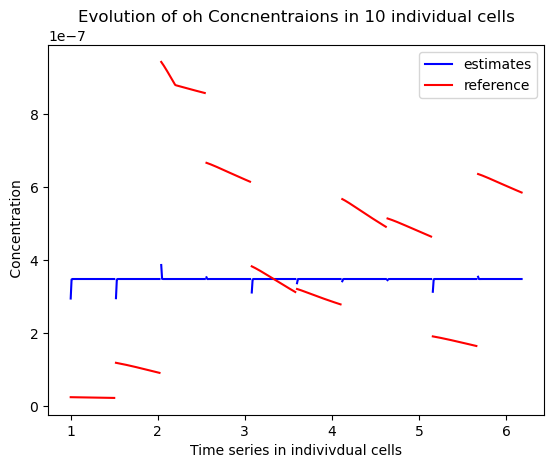

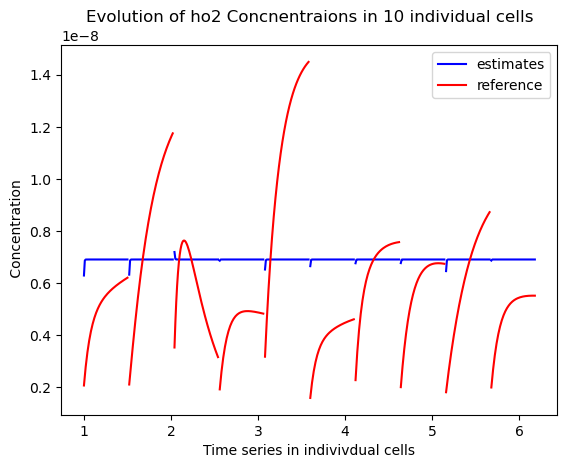

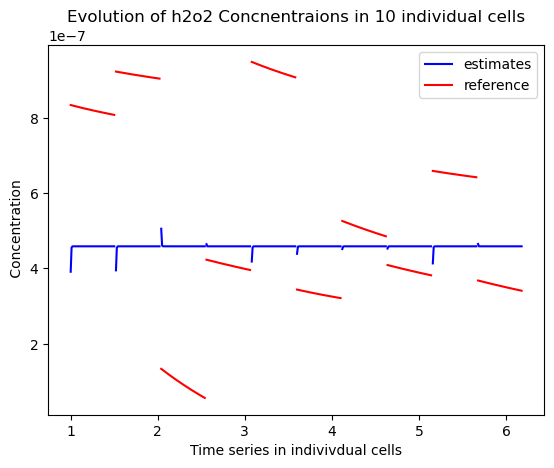

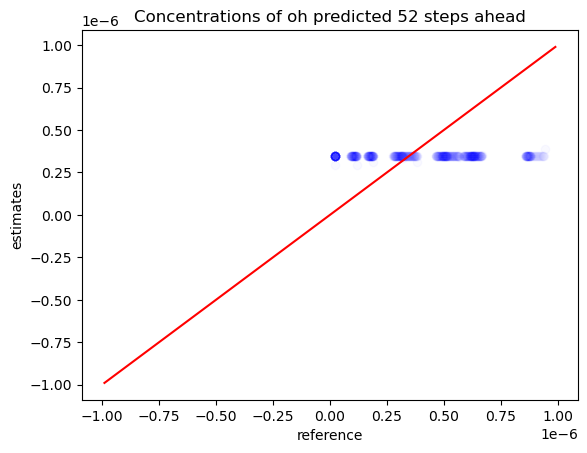

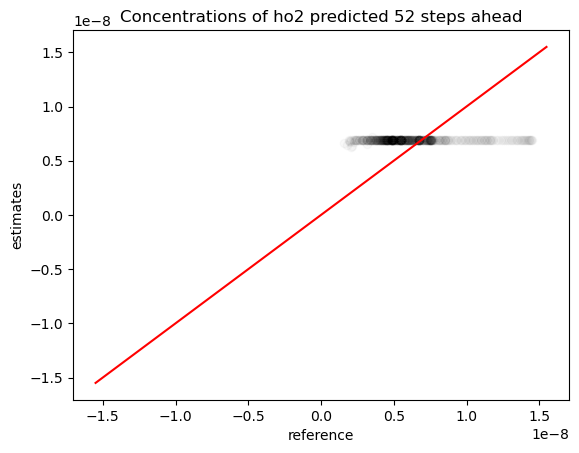

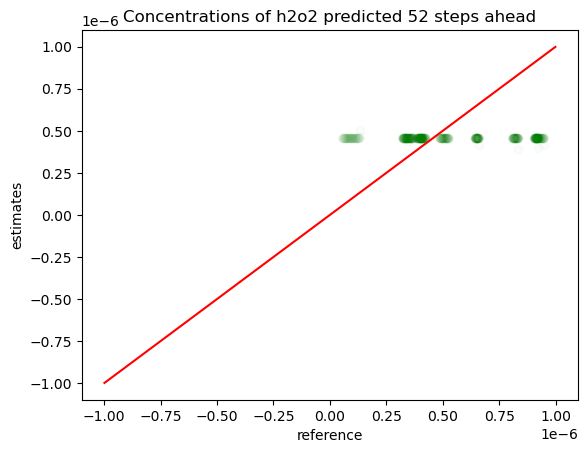

np.abs(dreference) 4.1203991139391444e-09


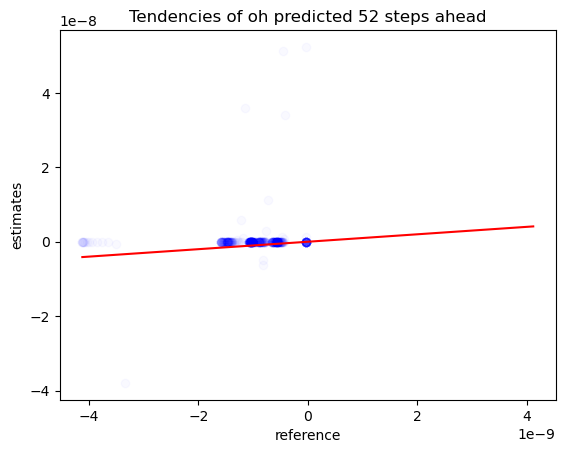

np.abs(dreference) 9.516933229489588e-10


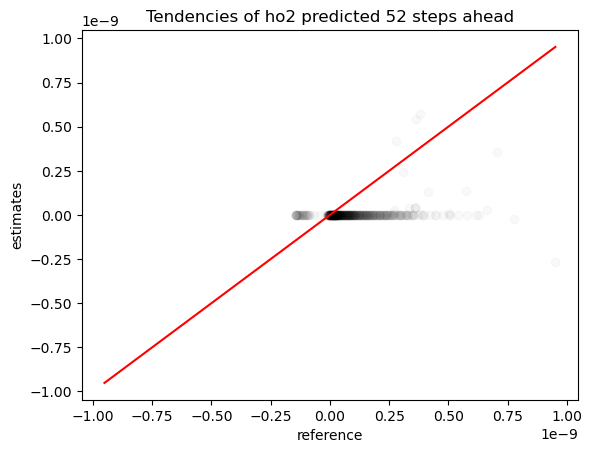

np.abs(dreference) 1.7838383971760313e-09


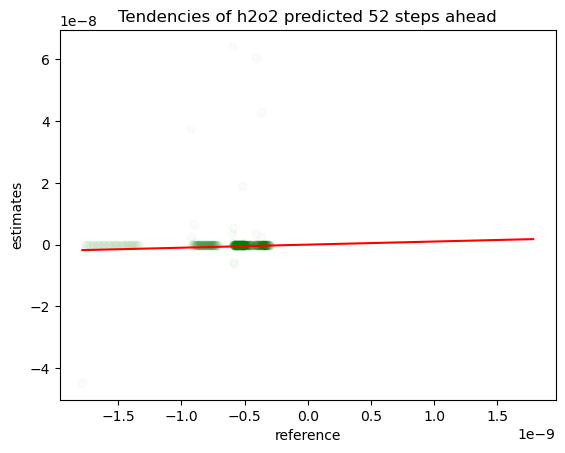

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""Created on Mon Feb 27 13:36:38 2023.

@author: andreyvlasenko
"""

import numpy as np
import torch
import torch.optim as optim

from auxiliary_functions import (
    zeros_counter,
)

from utilities import Utility, save_model_and_data

from visualization import (
    scatter_plots,
    visualization_of_cost_decay,
    visualizing_concentrations_in_grid_cells,
)


from Data_preparation import data_preparation
from model_creation_and_training import loss_fun, MLP, train_one_epoch

########################  The driver  ##################


length = 1  # length of predicting concentration data series
# building5 a perceptron


species = ["oh", "ho2", "h2o2"]
path = '../../../concentrations/' #"../../../concentrations_merge/"


batch = 1256  # batch size
num_of_epochs = 25

individual_cells = 20
start_of_timeseries = 1
observing_time_period = 53 #1430

alp = 0.025

model_name = "Regularizer_check_24"

utility = Utility(
    bilinear=False,
    species=species,
    trajectory_length= 1,
    visualize_results=False,
    penalty_factor=0,
    start_of_recursion=0,
    end_of_recursion = 1,
    concentrations_multiplier = 3.0,
    tendencies_multiplier = 1.0,
    second_derivative_multiplier = 1.0,
    tendencies = False,
    tendencies_and_2nd_derivative = False,
)


print("PREPARING THE DATA")
train_set, _,  x_train, y_train, y_test = data_preparation(path, length, utility, batch)
print("THE DATA HAS BEEN PREPARED")

#np.save('y_test.py', y_test)


In [ ]:
model = MLP(
    utility,
    hidden_dims=[9,9],   
)

optimizer = optim.Adam(model.parameters(), lr=2e-4)
#save_model_and_data(model, utility, "basis", [0], 0, "save", "../../MLP_output/")


Loss = []
cost0 = 1

for epoch_id in range(num_of_epochs):
    print("epoch_id = ", epoch_id)

    cost, cost0 = train_one_epoch(model, optimizer, train_set, utility, epoch_id, cost0)
    break
    Loss = Loss + [(cost)]

num_of_negative_values = zeros_counter(
    model,
    y_test,
    utility,
    start_of_timeseries,
    "concentrations",
    cost0,
    individual_cells=270,
    observing_time_period = observing_time_period ,
)

print("*****************")
print("Number of negative values = ", num_of_negative_values)
print("*****************")


# ======================= Visualization Block ===============================

""" Visualization of the training process"""

#visualization_of_cost_decay(Loss)

"""
Plotting individual time series in a single grap

Plotting concentraion time seria of the ground truth (further reference) and
network estimates for N cells in separate figures gives 2N graphs and N figures,
which is too much for visual analysis if N>4. To overcome visualization dificulties
we concatinate graphs for individual cells. """

#y_test = torch.tensor(y_test, dtype=torch.float)

In [ ]:


#y_test1 = np.load('y_test.npy')

individual_cells = 10
observing_time_period = 52
visualizing_concentrations_in_grid_cells(
    model,
    y_test,
    utility,
    start_of_timeseries,
    "concentrations",
    individual_cells,
    observing_time_period,
)

# print("y_ref.shape", y_test.shape, y_test[0, 0, :])

# """Scatter Plots """


print("Scatter Plots")

scatter_plots(
    model,
    y_test,
    utility,
    start_of_timeseries,
    "concentrations",
    individual_cells,
    alp,
    observing_time_period,
)

scatter_plots(
    model,
    y_test,
    utility,
    start_of_timeseries,
    "tendencies",
    individual_cells,
    alp,
    observing_time_period,
)
